In [ ]:
#from sklearn.decomposition import PCA
import numpy as np
#import scipy as sp
from sklearn.preprocessing import StandardScaler,MinMaxScaler    # Normalizing data
import matplotlib.pyplot as plt     # Plotting
import pandas as pd                 # data handling 
from sklearn.cluster import kmeans_plusplus

# To upload data in google colab click on the files symbol in the vertical toolbar to the left. It should be the 4th sign. Select the upload option and upload file from local system.

In [ ]:
class KMeans(object):                                                                               # a collection of functions which are related to each other 
    def __init__(self,k, init_type = 'rand'):
        self.k=k
        self.init_type = init_type                                                                  # Type of initialization to be used for KMeans algorithm

    def initialize_cluster_mean(self,X):                                                            # Initialize the cluster means. Two types of initialization: Kmeans++ and random
        if self.init_type=='rand':                                                                  # if init type == random, then ...
            indices=np.random.randint(X.shape[0],size=self.k)                                       # Choose k random data samples from X as cluster means
            cluster_mean=X[indices,:]                           
        elif self.init_type == 'kmeans++':                                                          # else if init type == kmeans++, then ...
            cluster_mean, indices = kmeans_plusplus(X, n_clusters=self.k, random_state=0)           # choose initial cluster means using kmeans++ algorithm
        return cluster_mean

    def update_cluster_mean(self,X,cluster_assignment):                                             # Cluster mean update step ( or Maximization step in the context of EM)
    ###     Inputs: 
    #       1.  X : Data Matrix; shape: NumSamples x InpDims
    #       2.  cluster_assignment: Array of shape (NumSamples,). The i-th element 
    #                           consists of a number between 0 to K-1 representing 
    #                           the cluster that the i-th data sample (corr. to i-th row in X) 
    #                           belongs to according to the latest update.

        cluster_mean=np.zeros((self.k,X.shape[1]))                                                  # Create a container of shape (K x InpDims) containing all zeros to keep the calculated cluster means
        for i in range(self.k):                                                                     # Loop over i = 0 to K-1
            X_i=X[np.where(cluster_assignment==i)]                                                  # Collect all the data samples that belong to the i-th cluster assignment
            cluster_mean[i,:]=np.mean(X_i,axis=0)                                                   # Find their sample mean and store as the i-th cluster mean 
        return cluster_mean

    def update_cluster_assignment(self,X,cluster_mean):                                             # Function to update cluster assignment (or Expectation step in the context of EM)
    
    ### Inputs:
    #   1.  X : Data Matrix; shape: NumSamples x InpDims 
    #   2. cluster_mean : Matrix of shape (K x InpDims) consisting of the latest
    #                     computed cluster mean.

        cluster_assignment=np.ones(X.shape[0])                                                      # Create a container of all ones of shape (NumSamples,) to store calculated cluster assignments
                                 
        for n in range(X.shape[0]):                                                                 # Loop over n = 0 to NumSamples -1
            
            dist=np.linalg.norm(cluster_mean-X[n,:],ord=2,axis=1)                                   # Calculate the L2 norms (or euclidean distances) of the n-th data sample from all the K cluster means
            cluster_assignment[n]=np.argmin(dist)                                                   # Assign the n-th data sample to that cluster whose mean is the closest to it. 
                                                                                                    # np.argmin(.) finds the index of the smallest element in an array
        return cluster_assignment                                               

    def fit(self,X):                                                                                # Fitting the data to the method
        cluster_mean=self.initialize_cluster_mean(X)                                                # Initialize Cluster Mean
        cluster_assignment=self.update_cluster_assignment(X,cluster_mean)                           # Update cluster assignment 
        cluster_mean_new=self.update_cluster_mean(X,cluster_assignment)                             # Calculate the latest cluster mean using the previous cluster assignment
        delta_mean=np.mean(np.linalg.norm(cluster_mean-cluster_mean_new,ord=2,axis=1))              # Calculate the diff. between the previous and current cluster means. This will be used to check if KMeans has converged.
        self.iter=0                                                                                         # To start iterating set i = 0

        if X.shape[1] > 2:                                                                          # For visualization of cluster means: (Optional)
            pca=PCA(n_components=2)                                                                 # If number of dimensions of X is greater than 2, use PCA to reduce the dimensionality of the cluster means to 2
            pca.fit(cluster_mean)
            self.k_mean_initial=pca.fit_transform(cluster_mean)
        else:
            self.k_mean_initial = cluster_mean                                                      # Else do nothing
        
        #fig=plt.figure()                                                                            # Initialize a matplotlib.pyplot figure
        #ax=plt.subplot(111)

        while(delta_mean>1e-6):                                                                     # while the difference between prev and curr cluster means is greater than a threshold, repeat
            cluster_mean=cluster_mean_new                                                           # Previous Cluster Mean <-- Current Cluster Mean                
            cluster_assignment=self.update_cluster_assignment(X,cluster_mean)                       # Update cluster assignement using previous cluster mean
            cluster_mean_new=self.update_cluster_mean(X,cluster_assignment)                         # Calculate the Current Cluster Mean using updated cluster assignments 
            delta_mean=np.mean(np.linalg.norm(cluster_mean-cluster_mean_new,ord=2,axis=1))          # Calculate delta mean
            self.iter+=1

        if X.shape[1] > 2:
            pca.fit(cluster_mean_new)                                                               # Store the final cluster means for visualization
            self.k_mean_final=pca.fit_transform(cluster_mean_new)
        else:
            self.k_mean_final = cluster_mean_new

        #marker_arr=['.','o','>','^','s','*','P','D','X','p']                                        # Plotting Function
        #for i in range(self.k):
        #    ax.scatter(self.k_mean_initial[i,0],self.k_mean_initial[i,1],marker=marker_arr[i],c='r',s=100)
        #    ax.scatter(k_mean_final[i,0],k_mean_final[i,1],marker=marker_arr[i],c='g',s=100)

        #plt.title('Translation of cluster means')
        #plt.xlabel('X1')
        #plt.ylabel('X2')
        #fig.show()    

        return cluster_mean_new

    def assign_clusters(self,X_test,final_cluster_means):                                           # Function used for validation on new unseen data
    
    ### Inputs:
    #   1. X_test: Data Input, Shape: NSamples x InpDims
    #   2. final_cluster_means: Computed cluster means after doing kMeans.

        cluster_assignment=np.ones(X_test.shape[0])
        for n in range(X_test.shape[0]):
            dist=np.linalg.norm(final_cluster_means-X_test[n,:],ord=2,axis=1)
            cluster_assignment[n]=np.argmin(dist)
        return cluster_assignment

In [ ]:
data_test=pd.read_csv('penguins_size.csv').dropna()

In [ ]:
data_test.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [ ]:
                             # Data cleaning

X=data_test.iloc[:,4:6].values                                                  # Length of fins and body mass
y=data_test['species']

uniq, counts = np.unique(np.asarray(y), return_counts=True)                                     # Count the number of unique entries in y
y.replace(uniq,[0, 1, 2], inplace=True)                                                         # Replace the three unique species names with -1, 0 and 1
y = y.values                                                                                    # Convert y to numpy array

print(uniq)

['Adelie' 'Chinstrap' 'Gentoo']


In [ ]:
scaler=StandardScaler()
scaler.fit(X)
X=scaler.fit_transform(X)

In [ ]:
k_means=KMeans(len(uniq), init_type='rand')                                                     # An observation: Using 'rand' as the init_type leads to different cluster initializations
final_cluster_mean=k_means.fit(X)                                                               # at different runs and also the number of iteratiosn required are in general greater than
assigned_clusters=k_means.assign_clusters(X,final_cluster_mean)                                 # what is required when init_type is 'kmeans++'.
print('Iterations required to converge: '+str(k_means.iter))                                    # Check this out by running the algo multiple times using 'rand' and 'kmeans++' initializer

Iterations required to converge: 19


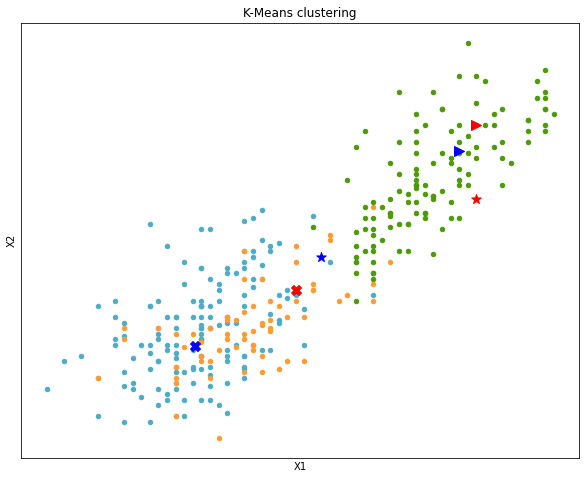

In [ ]:
plt.figure(figsize=(10,8))
colors = ["#4EACC5", "#FF9C34", "#4E9A06"]
for k, col in enumerate(colors):
    cluster_data = y == k
    plt.scatter(X[cluster_data, 0], X[cluster_data, 1], c=col, marker="o", s=20)
marker_type = ['X','>','*']
for k in range(len(colors)):
    plt.scatter(final_cluster_mean[k, 0], final_cluster_mean[k, 1], c="b", marker=marker_type[k],s=100)
for k in range(len(colors)):
    plt.scatter(k_means.k_mean_initial[k, 0], k_means.k_mean_initial[k, 1], c="r", marker=marker_type[k],s=100)
plt.xticks([])
plt.yticks([])
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('K-Means clustering')
plt.show()